# Descrition: 
This notebook contains the transformer being trained on all the aggregared data, using MNI and functional coordinates (extracted by PSC or MSC) method. The objective is reconstruction of masked brain region. where an entire brain region (all electodes in that region) are hidden from input, and reconstructed in the outpus using only electrode coordinates (whether MNI or Functional coordinates extarcted from first 10second of training data). Here 1 second of data is being used as input and prediction length. 


# Import libraries

In [1]:
# general libraries
from torch.utils.data import DataLoader
from scipy.io import loadmat
from scipy.spatial.distance import pdist, squareform

In [2]:
# local libraries
from src.tools.simulation import *
from src.models.CNN_encoder import *
from src.models.Functional_transformer import *
from src.signal.signal_processing import *
from src.pipelines.embedding_data_preparation import *
from src.pipelines.transformer_data_preparation import *
from src.utils.utils import *
from src.training.PSC_training import *
from src.training.visualize_embedding import *
from src.training.evaluation import *
from src.training.Transformer_training import *
from src.training.visualize_transformer_predictions import *

In [3]:
# dataset related libraries (have to replace these with your own dataset loading functions), replace with your own dataset source files
import sys
import os

directory_path = "D:/Python Projects/ICLR 2026/Dataset_Related"
sys.path.append(os.path.abspath(directory_path))
from dataset import * 

In [4]:
# Dataset related functions and mappings
# These functions should be customized for each subject and dataset, here example functions are provided


# Define which subjects and sessions to use. subjects are keys and sessions are values
# subject_sessions_with_mni = {
#     's1': ['p1'], 
#     's2': ['p1'], 
#     's3': ['p4', 'p6'], 
#     's4': ['p1', 'p2'],
#     's5': ['p1', 'p2', 'p3', 'p6', 'p7'],
#     's6': ['p1', 'p2'], 
#     's7': ['p1'], 
#     's8': ['p9'],
#     's9': ['p1', 'p2', 'p3'], 
#     's10': ['p6', 'p7', 'p8', 'p9'],
# }

# def get_true_region(subject, electrode_name, side, electrode_number, verbose=False):
#     """
#     This function defines the mapping from electrode name and contact number to true brain region for a given subject.
#     """
#     if verbose: print(f"using default arrangement for {subject}")
#     if 'GPi'.lower() in electrode_name.lower() and electrode_number in [4,5,6]:
#         return 'GPi'
#     elif 'VPLa'.lower() in electrode_name.lower() and electrode_number in [4,5,6]:
#         return 'VPla'
#     elif 'VoSTN'.lower() in electrode_name.lower() and electrode_number in [4,5,6]:
#         return 'VO'
#     elif 'VoSTN'.lower() in electrode_name.lower() and electrode_number in [1,2,3]:
#         return 'STN'
#     elif 'STN'.lower() in electrode_name.lower() and electrode_number in [4,5,6]: 
#         return 'STN'
#     elif 'VIM'.lower() in electrode_name.lower() and electrode_number in [4,5,6]:
#         return 'VIM'
#     elif 'PPN'.lower() in electrode_name.lower() and electrode_number in [1,2,3]:
#         return 'PPN'
#     elif 'VA'.lower() in electrode_name.lower() and electrode_number in [4,5,6]:
#         return 'VA'
#     elif 'VoaVop'.lower() in electrode_name.lower() and electrode_number in [4,5,6]:
#         return 'VoaVop'
#     elif 'VoaVop'.lower() in electrode_name.lower() and electrode_number in [4,5,6]:
#         return 'VoaVop'
#     else: 
#         return 'unknown'

# Configuration

In [5]:
# ----------- Config ------------ 

# CNN model paramters: 
EMBEDDING_DIM = 32

# dataset parameters
SAVE_DATASET = False  # if True: build & save; if False: load cached full datasets
LEN_TRAIN = 0.7
LEN_VAL = 0.15
LEN_TEST = 0.15
MAX_SESSION_LEN_SEC = 10*60 # maximum length of each session in seconds to make sure sessions are not too unbalanced
DATASET_WIN_MS = 1000.0
DATASET_HOP_MS = 500.0
BRAIN_SIDE_EXCLUDE = 'L'  # 'L' or 'R'
BRAIN_REGION_EXCLUDE = ['SNR', 'PPN', 'VA']  # list of regions to exclude from training and evaluation



# Build dataset 

In [ ]:
device = get_device()
# device = torch.device("cpu")
print(f" Using {device}")

cache_dir = "data/transformer_datasets"
os.makedirs(cache_dir, exist_ok=True)

# choose coordinate system here: can be -> functional_V1, functional_V2, mni
# and for control: channel, zero
embedding = "functional_V2" # 

if embedding == "functional_V1":
    # load pretrained functional encoder
    models = torch.load("D:\\Python Projects\\ICLR 2026 anonymized\\results\\multi_subject\\PSC_model\\full_siamese_model_best.pt", weights_only=False,map_location=device)  # device can be "cpu" or "cuda"
    models.eval()
    encoder= models.encoder
    encoder.eval()

if embedding == "functional_V2":
    # load pretrained functional encoder
    models = torch.load("D:\\Python Projects\\ICLR 2026 anonymized\\results\\multi_subject\\PSC_model\\full_siamese_model_best.pt", weights_only=False,map_location=device)  # device can be "cpu" or "cuda"
    models.eval()
    encoder= models.encoder
    encoder.eval()

# load mni coordinates
mni_coords = pd.read_csv("D:/transfer/mni info/electrodes_dataset.csv")

# define empty datasets to be filled
train_ds = MRCPStreamDataset(window_ms=DATASET_WIN_MS, hop_ms=DATASET_HOP_MS)
val_ds   = MRCPStreamDataset(window_ms=DATASET_WIN_MS, hop_ms=DATASET_HOP_MS)
test_ds  = MRCPStreamDataset(window_ms=DATASET_WIN_MS, hop_ms=DATASET_HOP_MS)

# determine func_emb_dim from encoder once
if embedding == "functional_V1" or embedding == "functional_V2":
    with torch.no_grad():
        dummy = torch.randn(1,1,10000, device=device)
        func_emb_dim = encoder.embed(dummy).shape[-1]

dataPath = "D:/transfer/micro voluntary dataset/lfs data"

# setup saving locations for datasets
dataset_tag = f"{embedding}_win{int(DATASET_WIN_MS)}_hop{int(DATASET_HOP_MS)}"
full_train_path = os.path.join(cache_dir, f"FULL_train_{dataset_tag}.pt")
full_val_path   = os.path.join(cache_dir, f"FULL_val_{dataset_tag}.pt")
full_test_path  = os.path.join(cache_dir, f"FULL_test_{dataset_tag}.pt")


if SAVE_DATASET:
    subject_counter = 0
    for isubject in subject_sessions_with_mni:
        subject_counter += 1
        for iperiod in subject_sessions_with_mni[isubject]:
            session_signals_train = {}
            session_signals_val = {}
            session_signals_test = {}
            session_embeds  = {}     # ch -> (F,)
            session_regions = {}    # {channel: "GPi"/"STN"/...} true brain region labels
            fs_session = None
            channel_counter = -1
            
            path = os.path.join(dataPath, isubject, iperiod)

            # load microelectrode labels
            try:
                microelectrodes = load_micro_labels(os.path.join(path, "microLabels.mat"))
            except:
                mat_contents = loadmat(os.path.join(path, "microLabels.mat"))
                micro_labels = mat_contents['microLabels']
                microelectrodes = [str(label[0]) if isinstance(label, np.ndarray) else str(label)
                                    for label in micro_labels.squeeze()]

            # load microelectrode signals
            for microelectrode in microelectrodes:
                region, side, electrode = parse_label(microelectrode)
                true_region = get_true_region(isubject, region, side, electrode) 
                if true_region == 'unknown' or side==BRAIN_SIDE_EXCLUDE or true_region in BRAIN_REGION_EXCLUDE:
                    continue  # skip unlabeled channels
                true_region = true_region + side
                channel_counter = channel_counter + 1
                # load file
                mat_path = os.path.join(path, microelectrode + ".mat")
                try:
                    with h5py.File(mat_path, "r") as f:
                        raw_signal = np.array(f["data"]).squeeze()
                        fs = int(np.array(f["fs"]).squeeze())
                except FileNotFoundError:
                    print(f"Error loading {microelectrode} from {mat_path}. Skipping this channel.")
                    continue
                except (OSError, KeyError):
                    try:
                        mat = scipy.io.loadmat(mat_path)
                        raw_signal = np.array(mat["data"]).squeeze()
                        fs = int(np.array(mat["fs"]).squeeze())
                    except:
                        print(f"Error loading {microelectrode} from {mat_path}. Skipping this channel.")
                        continue

                if fs_session is None: fs_session = fs

                # Remove big 60Hz artifacts
                filtered_signal = notch_filter(raw_signal,fs)

                # Normalize session recording
                normalized_signal = normalize_signal(filtered_signal)

                # Apply notch filters at 60Hz and its harmonics
                normalized_signal = notch_filter(normalized_signal,fs,freq=60)
                normalized_signal = notch_filter(normalized_signal,fs,freq=120)
                normalized_signal = notch_filter(normalized_signal,fs,freq=180)

                # Apply lowpass filter
                signal = lowpass_filter(normalized_signal, cutoff=50, fs=fs, order=2)

                # Truncate or pad signal to MAX_SESSION_LEN_SEC
                if len(signal)> MAX_SESSION_LEN_SEC*fs:
                    signal = signal[:MAX_SESSION_LEN_SEC*fs]

                # split into train/val/test
                n =len(signal)
                train_end = int(n * LEN_TRAIN)
                val_end = int(n * (LEN_TRAIN + LEN_VAL))

                # grab the appropriate coordinate system 
                if embedding == "functional_V1":
                    segment = signal[0:int(fs*10)]
                    x = torch.tensor(segment, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, T)
                    embedding_vector = encoder.embed(x).detach().cpu().numpy().squeeze()

                elif embedding == "functional_V2":
                    segment = signal[0:int(fs*10)]
                    x = torch.tensor(segment, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, T)
                    embedding_vector = encoder.embed(x).detach().cpu().numpy().squeeze()

                elif embedding == "mni":
                    
                    _region_val = str(region).strip().casefold()

                    # correct for regin name mismatches
                    if isubject == SUBJECT1 and (_region_val =="voavop"): electrode+=3
                    if isubject == SUBJECT1 and (_region_val =="voavop" or _region_val =="stn"): _region_val = "vostn"
                    if isubject == SUBJECT10 and (_region_val =="vostnsnr"): _region_val = "vostn"
                    
                    # grab mni coordinates
                    _side_val   = str(side).strip().casefold()
                    _subject_val = f"{isubject}_{iperiod}".strip()  # <- if you want dynamic subject; else keep your fixed value
                    _region_mask  = mni_coords["region"].astype(str).str.strip().str.casefold().eq(_region_val)
                    _side_mask    = mni_coords["side"].astype(str).str.strip().str.casefold().eq(_side_val)
                    _number_mask  = pd.to_numeric(mni_coords["number"], errors="coerce").eq(electrode)
                    _micro_mask   = mni_coords["scale"].astype(str).str.strip().str.casefold().str.rstrip('s').eq("micro")
                    _subject_mask = mni_coords["subject"].astype(str).str.strip().eq(isubject)  # or use _subject_val

                    row = mni_coords[_region_mask & _micro_mask & _subject_mask & _side_mask & _number_mask].copy()
                    embedding_vector = np.array([row["x"], row["y"], row["z"]], dtype=float).squeeze()
                    print("mni coordinates: ", embedding_vector)

                    # Fallback if no match or multiple matches
                    if len(row) == 0:
                        # fallback to zeros or handle as you prefer
                        print("did not find MNI coordinates: ", _region_val)
                        embedding_vector = np.zeros(3, dtype=float)
                    else:
                        # if multiple, take the first
                        print("found multiple MNI coordinates")
                        r = row.iloc[0]
                        embedding_vector = np.array([r["x"], r["y"], r["z"]], dtype=float)

                elif embedding == "channel":
                    embedding_dim = EMBEDDING_DIM
                    embedding_vector = np.zeros(embedding_dim) 
                    embedding_vector[channel_counter]=1

                elif embedding == "zero":
                    embedding_dim = EMBEDDING_DIM
                    embedding_vector = np.zeros(embedding_dim) 
                
                # stash per-session
                session_signals_train[microelectrode] = signal[:train_end].astype(np.float32)
                session_signals_val[microelectrode] = signal[train_end:val_end].astype(np.float32)
                session_signals_test[microelectrode] = signal[val_end:].astype(np.float32)

                session_embeds[microelectrode]  = embedding_vector.astype(np.float32)
                session_regions[microelectrode] = true_region 


            # 1) add to FULL multi-subject datasets
            added = train_ds.add_session(
                session_path=path,
                fs=fs_session,
                signals=session_signals_train,
                embeds=session_embeds,
                region_map=session_regions
            )

            val_added = val_ds.add_session(
                session_path=path,
                fs=fs_session,
                signals=session_signals_val,
                embeds=session_embeds,
                region_map=session_regions
            )

            testadded = test_ds.add_session(
                session_path=path,
                fs=fs_session,
                signals=session_signals_test,
                embeds=session_embeds,
                region_map=session_regions
            )
            print(f"  -> MRCP windows added: {added} from S{subject_counter}/{iperiod}")

            # 2) also save per-subject-period datasets (train/val/test)
            sp_train_ds = MRCPStreamDataset(window_ms=DATASET_WIN_MS, hop_ms=DATASET_HOP_MS)
            sp_val_ds   = MRCPStreamDataset(window_ms=DATASET_WIN_MS, hop_ms=DATASET_HOP_MS)
            sp_test_ds  = MRCPStreamDataset(window_ms=DATASET_WIN_MS, hop_ms=DATASET_HOP_MS)

            _ = sp_train_ds.add_session(
                session_path=path, fs=fs_session,
                signals=session_signals_train, embeds=session_embeds, region_map=session_regions
            )
            _ = sp_val_ds.add_session(
                session_path=path, fs=fs_session,
                signals=session_signals_val, embeds=session_embeds, region_map=session_regions
            )
            _ = sp_test_ds.add_session(
                session_path=path, fs=fs_session,
                signals=session_signals_test, embeds=session_embeds, region_map=session_regions
            )

            sp_prefix = f"{isubject}_{iperiod}_{dataset_tag}"
            torch.save(sp_train_ds, os.path.join(cache_dir, f"{sp_prefix}_train.pt"))
            torch.save(sp_val_ds,   os.path.join(cache_dir, f"{sp_prefix}_val.pt"))
            torch.save(sp_test_ds,  os.path.join(cache_dir, f"{sp_prefix}_test.pt"))
            print(f"  -> Saved per-session datasets: S{subject_counter}_{iperiod}_{dataset_tag}_[train|val|test].pt")

    # After finishing all subjects/periods, save the FULL multi-subject datasets
    torch.save(train_ds, full_train_path)
    torch.save(val_ds,   full_val_path)
    torch.save(test_ds,  full_test_path)
    print(f"[CACHE] Saved FULL datasets to:\n  {full_train_path}\n  {full_val_path}\n  {full_test_path}")
else:
    # Load prebuilt FULL datasets (skips the subject/period loop)
    if not (os.path.exists(full_train_path) and os.path.exists(full_val_path) and os.path.exists(full_test_path)):
        raise FileNotFoundError(
            "Cached FULL datasets not found. Set SAVE_DATASET=True once to build and cache them.\n"
            f"Expected:\n  {full_train_path}\n  {full_val_path}\n  {full_test_path}"
        )
    train_ds = torch.load(full_train_path, map_location=device)
    val_ds   = torch.load(full_val_path,   map_location=device)
    test_ds  = torch.load(full_test_path,  map_location=device)
    print(f"[CACHE] Loaded FULL datasets from cache: tag={dataset_tag}")


# (optional) see how regions were mapped to ids
print("Region vocab:", train_ds.region_vocab)        
print(f"Total training windows: {len(train_ds)} samples")
print(f"Total validating windows: {len(val_ds)} samples")
print(f"Total testing windows: {len(test_ds)} samples")

 Using cuda


C:\Users\sijav\AppData\Local\Temp\ipykernel_47392\1056436470.py:248: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_ds = torch.load(full_train_path, map_location=device

[CACHE] Loaded FULL datasets from cache: tag=functional_V2_win1000_hop500
Region vocab: {'GPiR': 0, 'STNR': 1, 'VIMR': 2, 'VOR': 3}
Total training windows: 23682 samples
Total validating windows: 5035 samples
Total testing windows: 5035 samples


# Configure training 

In [ ]:
# transformer parameters
D_MODEL = 128 # model width
PATCH_MS = 25.0 # patch size in ms
TARGET_FS = 1000  # target sampling rate after patching
NHEAD = 4
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
FEEDFORWARD_DIM = 384

# training parameters
BATCH_SIZE = 128
EPOCHS = 150
DROPOUT = 0.2


 Using cuda
Excluded region ids: {3}
Total trainable parameters: 1,366,555

Trainable parameters by layer:
is_source                                          128
is_query                                           128
query_base                                         131,072
g_conv                                             1
g_func                                             1
conv_tok.weight                                    3,200
func_proj.weight                                   4,096
func_proj.bias                                     128
fuse.weight                                        32,768
fuse.bias                                          128
pre_ln_src.weight                                  128
pre_ln_src.bias                                    128
pre_ln_qry.weight                                  128
pre_ln_qry.bias                                    128
encoder.layers.0.self_attn.in_proj_weight          49,152
encoder.layers.0.self_attn.in_proj_bias            384
enc

d:\Python Projects\ICLR 2026 anonymized\anonymized-ICLR2026.venv\Lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(


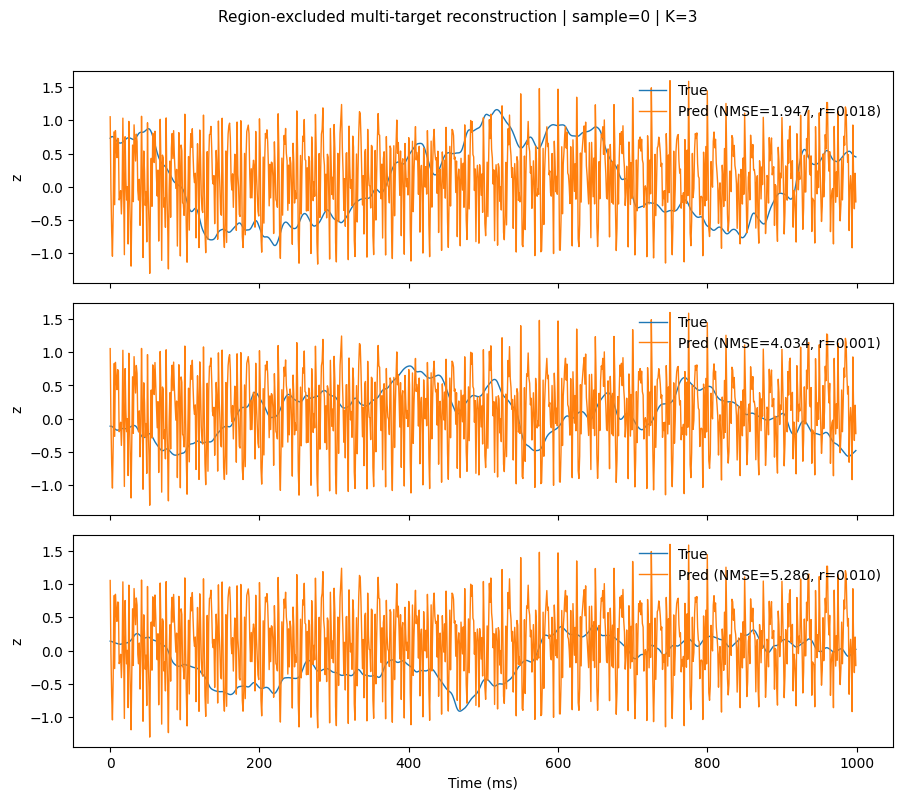

In [ ]:
print(f" Using {device}")
try:
    func_emb_dim = next(iter(session_embeds.values())).shape[0] 
    fs_common = fs_session 
except:
    func_emb_dim = EMBEDDING_DIM  # default value
    fs_common = 1000  

# --- pick which region(s) to exclude (e.g., all names starting with "VO") ---
excluded_ids = compute_excluded_region_ids(train_ds.region_vocab, predicate=lambda name: str(name).upper().startswith("VO"))
print("Excluded region ids:", excluded_ids)

# --- loaders ---
Kmax = None  # no limit on max number of query channels
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,
    collate_fn=lambda b: collate_region_exclude_train_multi(b, device, excluded_ids, Kmax=Kmax)
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,
    collate_fn=lambda b: collate_region_exclude_eval_multi(b, device, excluded_ids, Kmax=Kmax, order="maxvar")
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,
    collate_fn=lambda b: collate_region_exclude_eval_multi(b, device, excluded_ids, Kmax=Kmax, order="maxvar")
)

model = QueryReconTransformerPruned(
    func_emb_dim=func_emb_dim, fs=fs_common,
    d_model=D_MODEL, nhead=NHEAD, num_enc_layers=NUM_ENCODER_LAYERS, num_dec_layers=NUM_DECODER_LAYERS,
    patch_ms=PATCH_MS, stride_ms=None, dim_ff=FEEDFORWARD_DIM, dropout=DROPOUT
).to(device)


# setup optimizer with different lrs for head and body
params = []
for n,p in model.named_parameters():
    if not p.requires_grad: continue
    params.append({"params":[p], "lr":2e-4 if not n.startswith("head") else 3e-4,
                   "weight_decay":1e-4 if needs_wd(n,p) else 0.0})
opt = torch.optim.AdamW(params, betas=(0.9,0.99), eps=1e-8)

# print model parameters
count_parameters(model)
print("embedding type: (", embedding,") embedding size:", func_emb_dim)

# visualize query example for control before training
plot_query_example_region_exclude_multi(model, val_loader, fs=fs_common, device=device, sample_idx=0, max_k=None)

# Train transformer

In [ ]:
mse = nn.MSELoss()
results_dir = "results/transformer_training_" + embedding
os.makedirs(results_dir, exist_ok=True)

print("training...")
best_val_nmse = float("inf")

for epoch in range(1, EPOCHS+1):
    # ================== Train ==================
    model.train()
    tr_sum = tr_n = 0.0
    for batch in train_loader:
        # guard against empty/short
        if batch[0].numel() == 0 or batch[0].shape[-1] < model.patch_len:
            continue

        # Unpack multi-target batch:
        waves_src, fembs_src, ch_counts, pad_mask, fembs_tgt, tgt_pad_mask, y_true = batch

        # Forward: (B, K, Tm)
        y_hat = model(waves_src, fembs_src, pad_mask, fembs_tgt, tgt_pad_mask)
        Tm = y_hat.shape[-1]

        # Compute training loss over valid targets
        y_hat_v, y_true_v = flatten_valid(y_hat, y_true[:, :, :Tm], tgt_pad_mask)
        if y_hat_v is None:
            continue

        loss_mse  = torch.nn.functional.mse_loss(y_hat_v, y_true_v)
        loss_corr = corr_loss(y_hat_v, y_true_v)  # existing loss (1 - r)
        loss = loss_mse + 0.05 * loss_corr

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        bs = waves_src.size(0)
        tr_sum += loss.item() * bs
        tr_n   += bs

    # ================== Validation ==================
    model.eval()
    va_sum = va_n = 0.0
    val_nmse_list, val_nrmse_list, val_r_list = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            if batch[0].numel() == 0 or batch[0].shape[-1] < model.patch_len:
                continue
            waves_src, fembs_src, ch_counts, pad_mask, fembs_tgt, tgt_pad_mask, y_true = batch
            y_hat = model(waves_src, fembs_src, pad_mask, fembs_tgt, tgt_pad_mask)  # (B,K,Tm)
            Tm = y_hat.shape[-1]

            # Loss for logging (same as train)
            y_hat_v, y_true_v = flatten_valid(y_hat, y_true[:, :, :Tm], tgt_pad_mask)
            if y_hat_v is None:
                continue
            loss_mse  = torch.nn.functional.mse_loss(y_hat_v, y_true_v)
            loss_corr = corr_loss(y_hat_v, y_true_v)
            loss = loss_mse + 0.05 * loss_corr

            bs = waves_src.size(0)
            va_sum += loss.item() * bs
            va_n   += bs

            # Metrics: NMSE / NRMSE / r across valid targets
            nmse_mean, nrmse_mean, r_mean = nmse_nrmse_r(y_hat_v, y_true_v)
            val_nmse_list.append(nmse_mean)
            val_nrmse_list.append(nrmse_mean)
            val_r_list.append(r_mean)

    # Aggregate validation metrics
    val_nmse = float(np.mean(val_nmse_list)) if len(val_nmse_list) else float("inf")
    val_nrmse = float(np.mean(val_nrmse_list)) if len(val_nrmse_list) else float("inf")
    val_r = float(np.mean(val_r_list)) if len(val_r_list) else float("-inf")

    tr_loss = tr_sum / max(1.0, tr_n)
    va_loss = va_sum / max(1.0, va_n)

    print(f"Epoch {epoch:03d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"val_NMSE={val_nmse:.4f} | val_NRMSE={val_nrmse:.4f} | val_r={val_r:.4f}")

    # Save best-by-val NMSE
    if val_nmse < best_val_nmse:
        best_val_nmse = val_nmse
        best_path = os.path.join(results_dir, "model_best_by_val_nmse.pt")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": opt.state_dict(),
            "val_nmse": val_nmse,
            "val_nrmse": val_nrmse,
            "val_r": val_r,
            "val_loss": va_loss,
        }, best_path)
        best_path = os.path.join(results_dir, "model_best_by_val_nmse_full.pt")
        torch.save(model, best_path)
        print(f"  ↳ Saved new BEST checkpoint (val_NMSE={val_nmse:.4f}) → {best_path}")

    # (optional) Always save last
    last_path = os.path.join(results_dir, "model_last.pt")
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": opt.state_dict(),
        "val_nmse": val_nmse,
        "val_nrmse": val_nrmse,
        "val_r": val_r,
        "val_loss": va_loss,
    }, last_path)
    last_path = os.path.join(results_dir, "model_last_full.pt")
    torch.save(model, last_path)


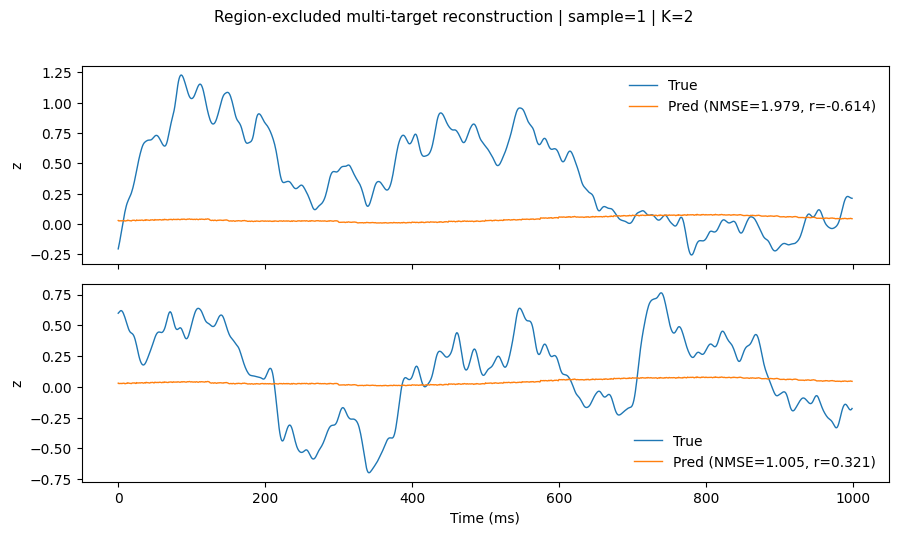

In [ ]:
plot_query_example_region_exclude_multi(model, test_loader, fs=fs_common, device=device, sample_idx=1, max_k=None,random_batch=True)